# Universal Approximation Theorem: From Function Spaces to Neural Networks

## Mathematical Foundations: Function Spaces

To understand what neural networks can approximate, we need a mathematical framework for measuring "closeness" between functions. This leads us to function spaces.

### Banach Spaces: The Setting for Approximation

A **Banach space** is a complete normed vector space. For our purposes:

1. **Vector Space of Functions**: We can add functions and multiply by scalars
   - $(f + g)(x) = f(x) + g(x)$
   - $(\alpha f)(x) = \alpha \cdot f(x)$

2. **Norm**: A way to measure the "size" of a function
   - $L^\infty$ norm (supremum): $\|f\|_\infty = \sup_{x \in [a,b]} |f(x)|$
   - $L^2$ norm: $\|f\|_2 = \left(\int_a^b |f(x)|^2 dx\right)^{1/2}$
   - $L^1$ norm: $\|f\|_1 = \int_a^b |f(x)| dx$

3. **Completeness**: Cauchy sequences converge to a limit in the space

### Hilbert Spaces: Adding Geometry

A **Hilbert space** is a Banach space with an inner product:

$$\langle f, g \rangle = \int_a^b f(x)g(x) dx$$

This enables:
- **Orthogonality**: $\langle f, g \rangle = 0$ means $f$ and $g$ are orthogonal
- **Projections**: Finding the best approximation in a subspace
- **Basis expansions**: $f = \sum_{i=1}^\infty c_i \phi_i$ where $\{\phi_i\}$ is an orthonormal basis

### Density: The Key Concept

A subset $S$ is **dense** in a space $X$ if:

$$\forall f \in X, \forall \epsilon > 0, \exists g \in S : \|f - g\| < \epsilon$$

In words: Every function in $X$ can be approximated arbitrarily well by functions from $S$.

**The Universal Approximation Theorem states**: Neural networks form a dense subset in $C([a,b])$ (continuous functions on $[a,b]$).

## Universal Approximation Theorem: Two Proofs

### 1. Constructive Proof with ReLU

The ReLU activation $\text{ReLU}(x) = \max(0, x)$ allows us to build approximations constructively.

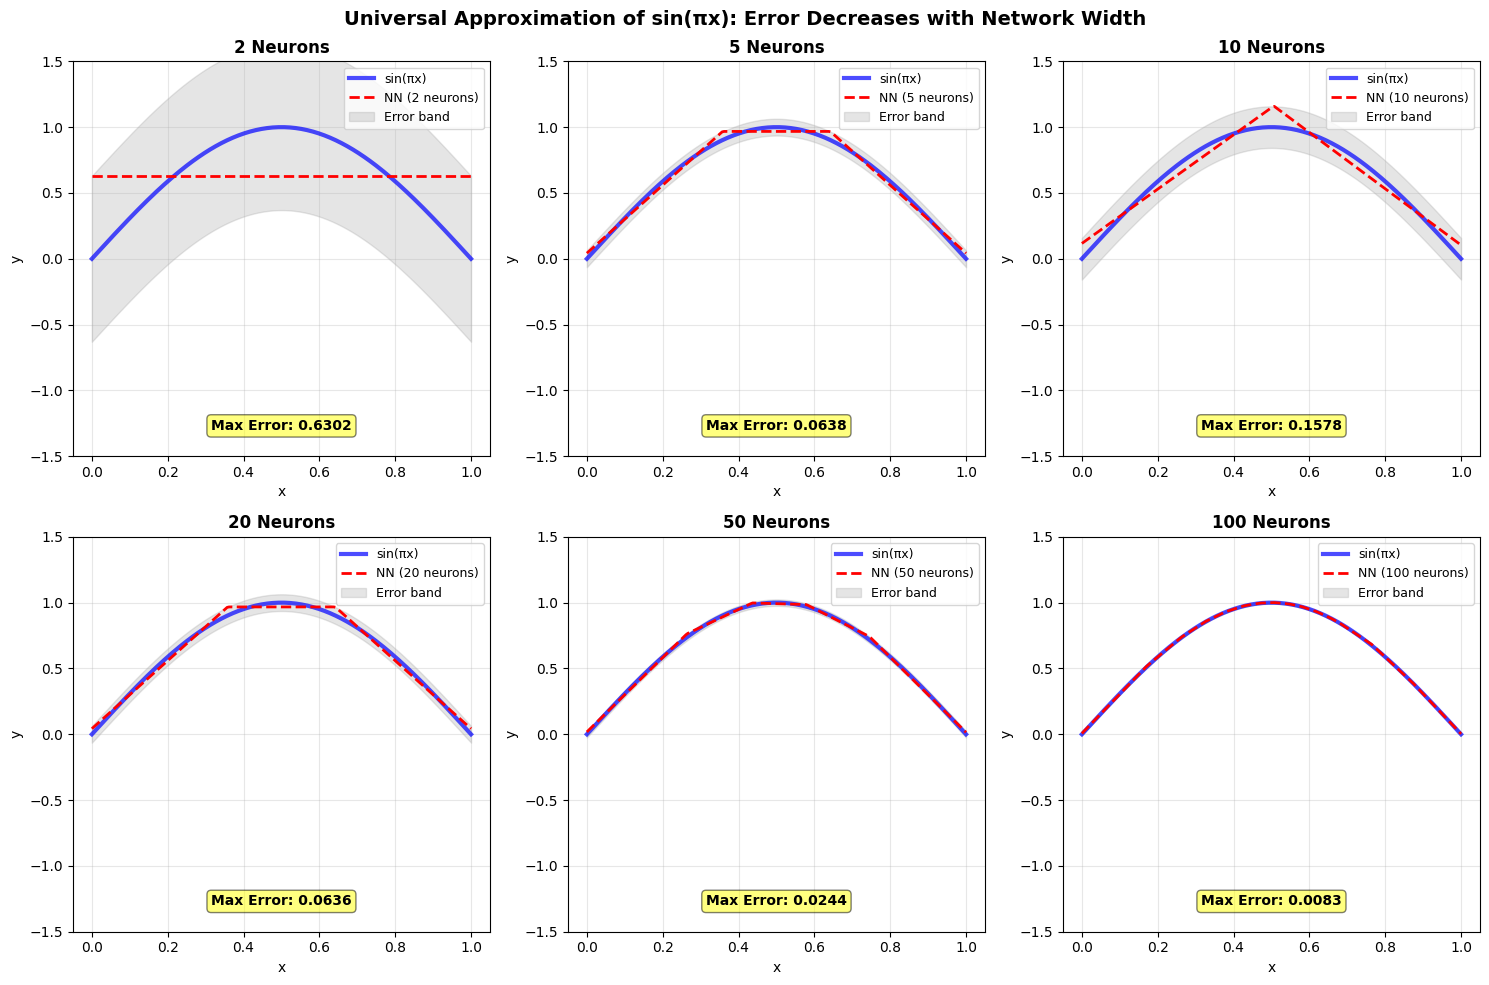

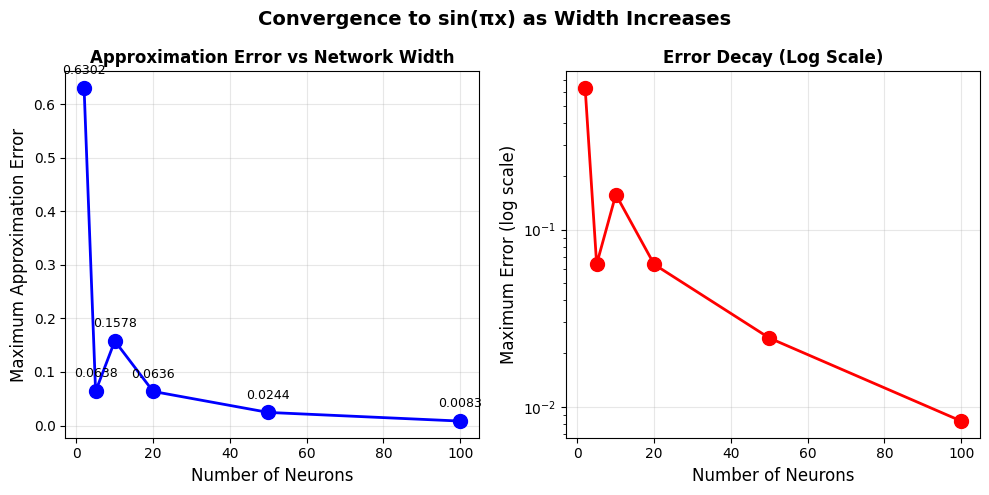

Universal Approximation Theorem Demonstrated for sin(πx):
Width      Max Error       Improvement    
----------------------------------------
2          0.630201        (baseline)     
5          0.063754        9.88           x
10         0.157844        3.99           x
20         0.063631        9.90           x
50         0.024449        25.78          x
100        0.008308        75.86          x

As the number of neurons increases from 2 to 100:
Error decreases by 75.9x


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random

class ReLUNet(nn.Module):
    def __init__(self, width):
        super().__init__()
        self.hidden = nn.Linear(1, width)
        self.output = nn.Linear(width, 1)
        
        # Glorot initialization
        nn.init.xavier_normal_(self.hidden.weight)
        nn.init.xavier_normal_(self.output.weight)
        nn.init.zeros_(self.hidden.bias)
        nn.init.zeros_(self.output.bias)
    
    def forward(self, x):
        return self.output(torch.relu(self.hidden(x)))

def target_sinpi(x):
    return np.sin(np.pi * x)

# Create training data
x_train = torch.linspace(0, 1, 100).reshape(-1, 1)
y_train = torch.tensor([target_sinpi(x.item()) for x in x_train], dtype=torch.float32).reshape(-1, 1)

# Train networks with different widths
widths = [2, 5, 10, 20, 50, 100]
models = []
errors = []

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, width in enumerate(widths):
    best_model = None
    best_error = float('inf')
    
    # Multiple restarts to avoid bad local minima
    for trial in range(5):
        model = ReLUNet(width)
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        criterion = nn.MSELoss()
        
        # Train
        epochs = max(3000, width * 30)
        for epoch in range(epochs):
            optimizer.zero_grad()
            y_pred = model(x_train)
            loss = criterion(y_pred, y_train)
            loss.backward()
            optimizer.step()
        
        # Evaluate this trial
        x_test = torch.linspace(0, 1, 200).reshape(-1, 1)
        with torch.no_grad():
            y_pred = model(x_test).numpy().flatten()
            x_test_np = x_test.numpy().flatten()
            y_true = np.array([target_sinpi(x) for x in x_test_np])
            error = np.max(np.abs(y_true - y_pred))
        
        if error < best_error:
            best_error = error
            best_model = model
    
    models.append(best_model)
    errors.append(best_error)
    
    # Plot best result
    x_test = torch.linspace(0, 1, 200).reshape(-1, 1)
    with torch.no_grad():
        y_pred = best_model(x_test).numpy().flatten()
        x_test_np = x_test.numpy().flatten()
        y_true = np.array([target_sinpi(x) for x in x_test_np])
    
    axes[idx].plot(x_test_np, y_true, 'b-', linewidth=3, label='sin(πx)', alpha=0.7)
    axes[idx].plot(x_test_np, y_pred, 'r--', linewidth=2, label=f'NN ({width} neurons)')
    axes[idx].fill_between(x_test_np, y_true - best_error, y_true + best_error,
                           alpha=0.2, color='gray', label='Error band')
    axes[idx].set_title(f'{width} Neurons', fontweight='bold')
    axes[idx].set_xlabel('x')
    axes[idx].set_ylabel('y')
    axes[idx].legend(loc='upper right', fontsize=9)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_ylim(-1.5, 1.5)
    
    axes[idx].text(0.5, -1.3, f'Max Error: {best_error:.4f}',
                   ha='center', fontsize=10, fontweight='bold',
                   bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

plt.suptitle('Universal Approximation of sin(πx): Error Decreases with Network Width',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Plot error vs width
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(widths, errors, 'bo-', linewidth=2, markersize=10)
plt.xlabel('Number of Neurons', fontsize=12)
plt.ylabel('Maximum Approximation Error', fontsize=12)
plt.title('Approximation Error vs Network Width', fontweight='bold')
plt.grid(True, alpha=0.3)
for i, (w, e) in enumerate(zip(widths, errors)):
    plt.annotate(f'{e:.4f}', (w, e), textcoords="offset points",
                 xytext=(0,10), ha='center', fontsize=9)

plt.subplot(1, 2, 2)
plt.semilogy(widths, errors, 'ro-', linewidth=2, markersize=10)
plt.xlabel('Number of Neurons', fontsize=12)
plt.ylabel('Maximum Error (log scale)', fontsize=12)
plt.title('Error Decay (Log Scale)', fontweight='bold')
plt.grid(True, alpha=0.3)

plt.suptitle('Convergence to sin(πx) as Width Increases', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Universal Approximation Theorem Demonstrated for sin(πx):")
print(f"{'Width':<10} {'Max Error':<15} {'Improvement':<15}")
print("-" * 40)
for i, (w, e) in enumerate(zip(widths, errors)):
    if i == 0:
        print(f"{w:<10} {e:<15.6f} {'(baseline)':<15}")
    else:
        improvement = errors[0] / e
        print(f"{w:<10} {e:<15.6f} {improvement:<15.2f}x")

print(f"\nAs the number of neurons increases from {widths[0]} to {widths[-1]}:")
print(f"Error decreases by {errors[0]/errors[-1]:.1f}x")

### Key Insight from Constructive Proof

The constructive proof shows:
1. **Two ReLU units** create a "bump" function
2. **Multiple bumps** approximate step functions
3. **Finer steps** (more neurons) → better approximation
4. As $n \to \infty$, we can achieve any desired accuracy $\epsilon$

### 2. Proof by Contradiction (Hahn-Banach)

We'll prove UAT using our familiar function $\sin(\pi x)$ to make the contradiction concrete and visual.

#### The Setup: Assume Neural Networks CANNOT Approximate sin(πx)

**Assumption**: There exists some $\epsilon > 0$ such that for ANY neural network $N$ with sigmoid activations:
$$\|\sin(\pi x) - N(x)\|_\infty > \epsilon$$

This means there's a "forbidden zone" around $\sin(\pi x)$ that no neural network can enter.

#### The Key Insight: If There's a Gap, There's a Detector

If neural networks truly can't approximate $\sin(\pi x)$, then there must exist a linear functional $L$ (think "function detector") such that:
- $L(\sin(\pi x)) \neq 0$ (it "sees" our target function)
- $L(N) = 0$ for EVERY neural network $N$ (it's "blind" to all neural networks)

By the Riesz Representation Theorem, this functional corresponds to a signed measure $\mu$ with the magical property:
$$\int \sigma(wx + b) \, d\mu(x) = 0$$
for EVERY choice of weight $w$ and bias $b$.


#### The Mathematical Details: Step by Step

**Step 1: Sigmoids Approximate Step Functions**

For large $\lambda$, the sigmoid $\sigma(\lambda(wx + b))$ approaches:
$$\chi_{H}(x) = \begin{cases} 1 & \text{if } wx + b > 0 \\ 0 & \text{if } wx + b < 0 \end{cases}$$

This is the characteristic function of the half-space $H = \{x : wx + b > 0\}$.

**Step 2: The Measure Must Annihilate ALL Half-spaces**

If $\mu$ makes every sigmoid integrate to zero, then by taking limits:
$$\int \chi_{H} \, d\mu = 0 \quad \text{for every half-space } H$$

**Step 3: Half-spaces Can Isolate Any Point**

For any point $a \in [0,1]$ and $\delta > 0$, the interval $[a-\delta, a+\delta]$ can be written as:
$$[a-\delta, a+\delta] = H_1 \cap H_2$$
where:
- $H_1 = \{x : x > a-\delta\} = \{x : x - (a-\delta) > 0\}$
- $H_2 = \{x : -x > -(a+\delta)\} = \{x : -x + (a+\delta) > 0\}$

Both are half-spaces! Since $\mu(H_1) = \mu(H_2) = 0$, we have $\mu([a-\delta, a+\delta]) = 0$.

**Step 4: Taking the Limit**

As $\delta \to 0$, the intervals $[a-\delta, a+\delta]$ shrink to the single point $\{a\}$. 
By continuity of measures: $\mu(\{a\}) = 0$ for every point $a$.

**Step 5: The Measure is Zero Everywhere**

Since every point has measure zero, and any set is a union of points:
$$\mu = 0 \text{ (the zero measure)}$$

**Step 6: The Contradiction**

But we needed:
- $\int \sin(\pi x) \, d\mu \neq 0$ (to detect our target function)
- $\mu = 0$ everywhere (from the half-space argument)

If $\mu = 0$, then $\int \sin(\pi x) \cdot 0 \, dx = 0$, contradicting our requirement!

**Conclusion**: Our assumption that neural networks cannot approximate $\sin(\pi x)$ leads to a contradiction. Therefore, neural networks CAN approximate $\sin(\pi x)$ (and by the same argument, any continuous function).

/var/folders/w8/xz590jyd7r36zmxcspgzj3z40000gn/T/ipykernel_89370/417646301.py:117: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral = np.trapz(product, x_int)
/var/folders/w8/xz590jyd7r36zmxcspgzj3z40000gn/T/ipykernel_89370/417646301.py:130: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral_sig = np.trapz(product_sig, x_int)


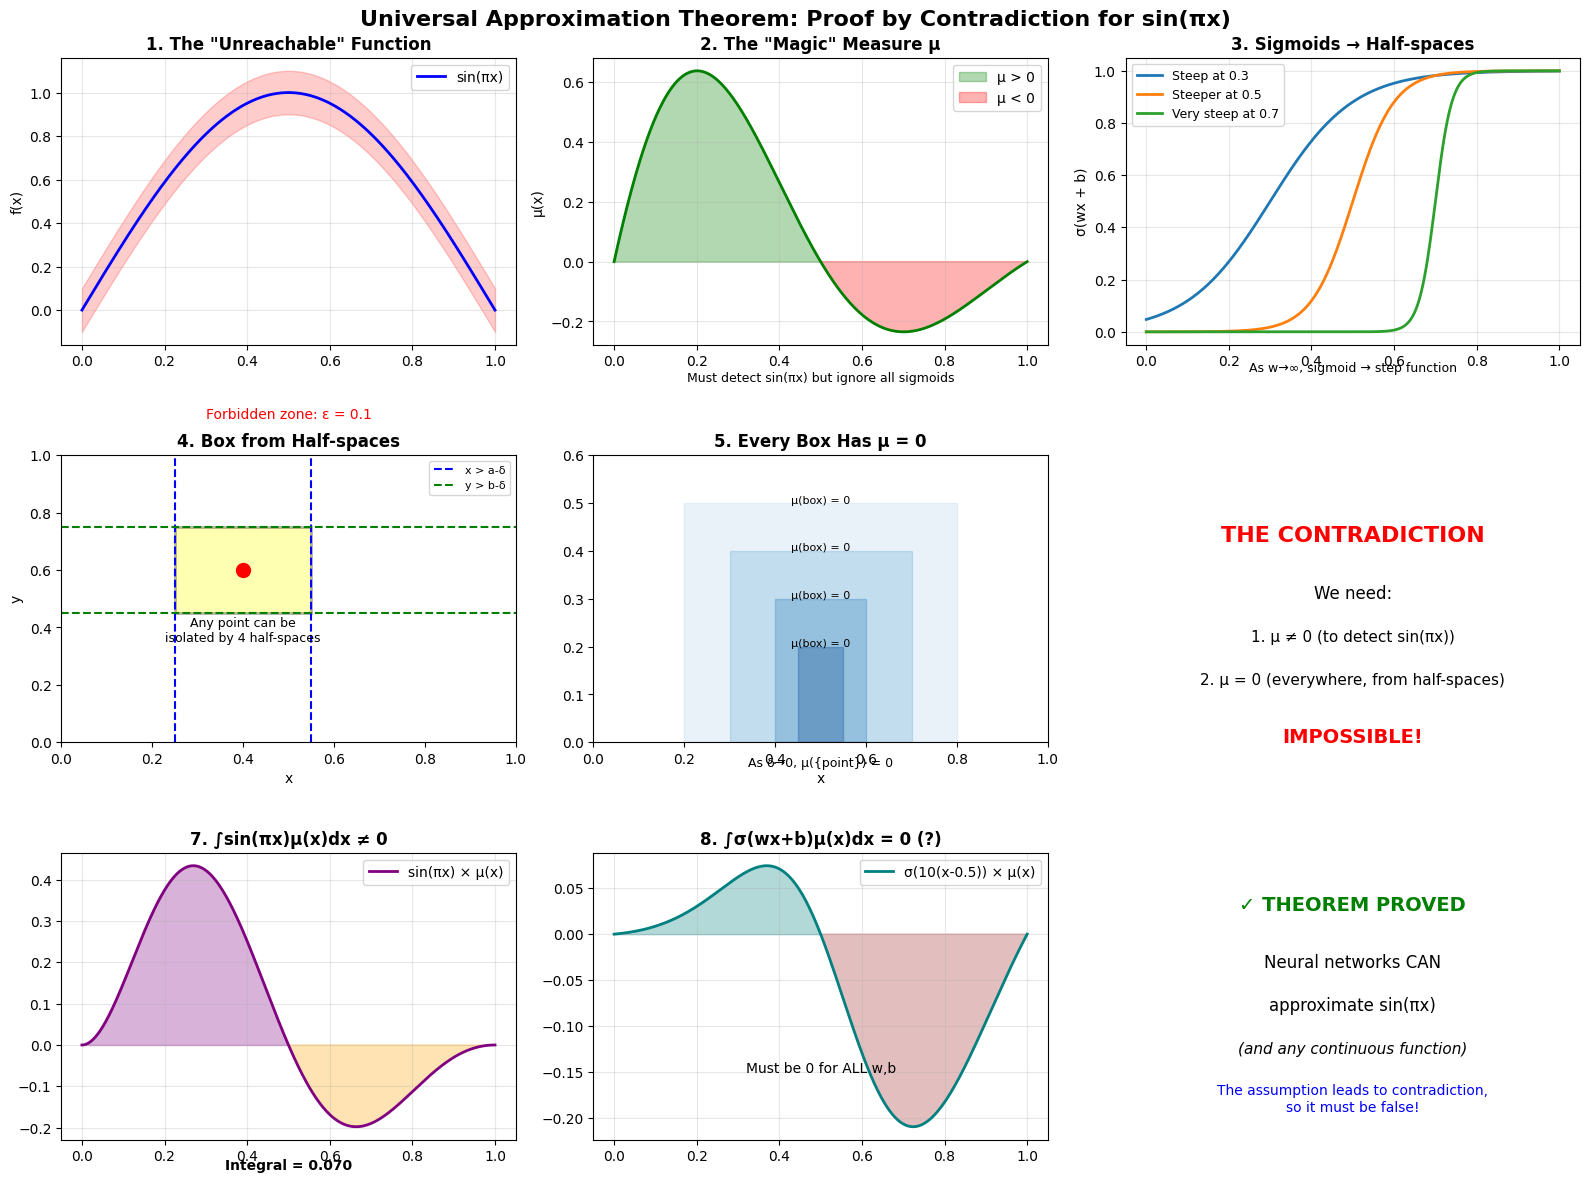

The contradiction proof shows that:
1. If we assume sin(πx) can't be approximated by neural networks
2. Then there must exist a measure μ that 'detects' sin(πx) but ignores all sigmoids
3. But sigmoids can create half-spaces that isolate any point
4. This forces μ = 0 everywhere
5. But then μ can't detect sin(πx) either!
6. Contradiction! Therefore, neural networks CAN approximate sin(πx)


In [ ]:
# Visualizing the Contradiction: Why sin(πx) MUST be approximable

# Let's demonstrate why the "impossible measure" leads to contradiction
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

# Our target function
def target_func(x):
    return np.sin(np.pi * x)

# Sigmoid function
def sigmoid(x, w=1, b=0):
    return 1 / (1 + np.exp(-w * (x - b)))

# Create figure with subplots
fig = plt.figure(figsize=(16, 12))

# Plot 1: The Setup - Assume sin(πx) can't be approximated
ax1 = plt.subplot(3, 3, 1)
x = np.linspace(0, 1, 500)
y_target = target_func(x)
ax1.plot(x, y_target, 'b-', linewidth=2, label='sin(πx)')
ax1.fill_between(x, y_target - 0.1, y_target + 0.1, alpha=0.2, color='red')
ax1.set_title('1. The "Unreachable" Function', fontweight='bold')
ax1.set_ylabel('f(x)')
ax1.text(0.5, -0.5, 'Forbidden zone: ε = 0.1', ha='center', color='red')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: The supposed "detector" measure μ
ax2 = plt.subplot(3, 3, 2)
# Create an oscillating "measure" that might detect sin(πx)
mu = lambda x: np.sin(2 * np.pi * x) * np.exp(-2 * x)
x_mu = np.linspace(0, 1, 500)
y_mu = mu(x_mu)
ax2.plot(x_mu, y_mu, 'g-', linewidth=2)
ax2.fill_between(x_mu, 0, y_mu, where=(y_mu > 0), alpha=0.3, color='green', label='μ > 0')
ax2.fill_between(x_mu, 0, y_mu, where=(y_mu <= 0), alpha=0.3, color='red', label='μ < 0')
ax2.set_title('2. The "Magic" Measure μ', fontweight='bold')
ax2.set_ylabel('μ(x)')
ax2.text(0.5, -0.4, 'Must detect sin(πx) but ignore all sigmoids', ha='center', fontsize=9)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Show that sigmoids can create half-spaces
ax3 = plt.subplot(3, 3, 3)
x_sig = np.linspace(0, 1, 500)
for w, b, label in [(10, 0.3, 'Steep at 0.3'), (20, 0.5, 'Steeper at 0.5'), (50, 0.7, 'Very steep at 0.7')]:
    ax3.plot(x_sig, sigmoid(x_sig, w, b), linewidth=2, label=label)
ax3.set_title('3. Sigmoids → Half-spaces', fontweight='bold')
ax3.set_ylabel('σ(wx + b)')
ax3.text(0.5, -0.15, 'As w→∞, sigmoid → step function', ha='center', fontsize=9)
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# Plot 4: Half-spaces can isolate ANY point
ax4 = plt.subplot(3, 3, 4)
ax4.set_xlim(0, 1)
ax4.set_ylim(0, 1)
# Show how to isolate a point using half-spaces
point = (0.4, 0.6)
delta = 0.15
rect = Rectangle((point[0]-delta, point[1]-delta), 2*delta, 2*delta, 
                 fill=True, facecolor='yellow', alpha=0.3, edgecolor='black', linewidth=2)
ax4.add_patch(rect)
ax4.scatter(*point, color='red', s=100, zorder=5)
# Draw the half-space boundaries
ax4.axvline(x=point[0]-delta, color='blue', linestyle='--', label='x > a-δ')
ax4.axvline(x=point[0]+delta, color='blue', linestyle='--')
ax4.axhline(y=point[1]-delta, color='green', linestyle='--', label='y > b-δ')
ax4.axhline(y=point[1]+delta, color='green', linestyle='--')
ax4.set_title('4. Box from Half-spaces', fontweight='bold')
ax4.set_xlabel('x')
ax4.set_ylabel('y')
ax4.text(point[0], point[1]-0.25, 'Any point can be\nisolated by 4 half-spaces', 
         ha='center', fontsize=9)
ax4.legend(fontsize=8)

# Plot 5: Show the measure must be zero on every box
ax5 = plt.subplot(3, 3, 5)
x_box = np.linspace(0, 1, 100)
y_box = np.zeros_like(x_box)
# Show shrinking boxes
for i, delta in enumerate([0.3, 0.2, 0.1, 0.05]):
    center = 0.5
    ax5.fill_between([center-delta, center+delta], [0, 0], [0.5-i*0.1, 0.5-i*0.1], 
                     alpha=0.3, color=plt.cm.Blues(0.3 + i*0.2))
    ax5.text(center, 0.5-i*0.1, f'μ(box) = 0', ha='center', fontsize=8)
ax5.set_xlim(0, 1)
ax5.set_ylim(0, 0.6)
ax5.set_title('5. Every Box Has μ = 0', fontweight='bold')
ax5.set_xlabel('x')
ax5.text(0.5, -0.05, 'As δ→0, μ({point}) = 0', ha='center', fontsize=9)

# Plot 6: The contradiction emerges
ax6 = plt.subplot(3, 3, 6)
ax6.text(0.5, 0.7, 'THE CONTRADICTION', fontsize=16, fontweight='bold', ha='center', color='red')
ax6.text(0.5, 0.5, 'We need:', fontsize=12, ha='center')
ax6.text(0.5, 0.35, '1. μ ≠ 0 (to detect sin(πx))', fontsize=11, ha='center')
ax6.text(0.5, 0.2, '2. μ = 0 (everywhere, from half-spaces)', fontsize=11, ha='center')
ax6.text(0.5, 0.0, 'IMPOSSIBLE!', fontsize=14, fontweight='bold', ha='center', color='red')
ax6.set_xlim(0, 1)
ax6.set_ylim(0, 1)
ax6.axis('off')

# Plot 7: Show integral of sin(πx) with measure
ax7 = plt.subplot(3, 3, 7)
x_int = np.linspace(0, 1, 500)
y_target = target_func(x_int)
y_mu = mu(x_int)
product = y_target * y_mu
ax7.plot(x_int, product, 'purple', linewidth=2, label='sin(πx) × μ(x)')
ax7.fill_between(x_int, 0, product, where=(product > 0), alpha=0.3, color='purple')
ax7.fill_between(x_int, 0, product, where=(product <= 0), alpha=0.3, color='orange')
integral = np.trapezoid(product, x_int)
ax7.set_title('7. ∫sin(πx)μ(x)dx ≠ 0', fontweight='bold')
ax7.text(0.5, -0.3, f'Integral = {integral:.3f}', ha='center', fontsize=10, fontweight='bold')
ax7.legend()
ax7.grid(True, alpha=0.3)

# Plot 8: Show integral of sigmoid with measure
ax8 = plt.subplot(3, 3, 8)
y_sigmoid = sigmoid(x_int, 10, 0.5)
product_sig = y_sigmoid * y_mu
ax8.plot(x_int, product_sig, 'teal', linewidth=2, label='σ(10(x-0.5)) × μ(x)')
ax8.fill_between(x_int, 0, product_sig, where=(product_sig > 0), alpha=0.3, color='teal')
ax8.fill_between(x_int, 0, product_sig, where=(product_sig <= 0), alpha=0.3, color='brown')
integral_sig = np.trapezoid(product_sig, x_int)
ax8.set_title('8. ∫σ(wx+b)μ(x)dx = 0 (?)', fontweight='bold')
ax8.text(0.5, -0.15, f'Must be 0 for ALL w,b', ha='center', fontsize=10)
ax8.legend()
ax8.grid(True, alpha=0.3)

# Plot 9: Conclusion
ax9 = plt.subplot(3, 3, 9)
ax9.text(0.5, 0.8, '✓ THEOREM PROVED', fontsize=14, fontweight='bold', ha='center', color='green')
ax9.text(0.5, 0.6, 'Neural networks CAN', fontsize=12, ha='center')
ax9.text(0.5, 0.45, 'approximate sin(πx)', fontsize=12, ha='center')
ax9.text(0.5, 0.3, '(and any continuous function)', fontsize=11, ha='center', style='italic')
ax9.text(0.5, 0.1, 'The assumption leads to contradiction,\nso it must be false!', 
         fontsize=10, ha='center', color='blue')
ax9.set_xlim(0, 1)
ax9.set_ylim(0, 1)
ax9.axis('off')

plt.suptitle('Universal Approximation Theorem: Proof by Contradiction for sin(πx)', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("The contradiction proof shows that:")
print("1. If we assume sin(πx) can't be approximated by neural networks")
print("2. Then there must exist a measure μ that 'detects' sin(πx) but ignores all sigmoids")
print("3. But sigmoids can create half-spaces that isolate any point")
print("4. This forces μ = 0 everywhere")
print("5. But then μ can't detect sin(πx) either!")
print("6. Contradiction! Therefore, neural networks CAN approximate sin(πx)")

## Continuous vs Discontinuous: What Neural Networks Can and Cannot Approximate

### The Detector That Works for Discontinuities

Let's explore why neural networks with continuous activations struggle with true discontinuities. We'll create a specific "detector" (signed measure) that can identify a step function but annihilates continuous functions approximated by neural networks.

Consider a step function and a detector measure that's +1 on [0, 0.5) and -1 on [0.5, 1].

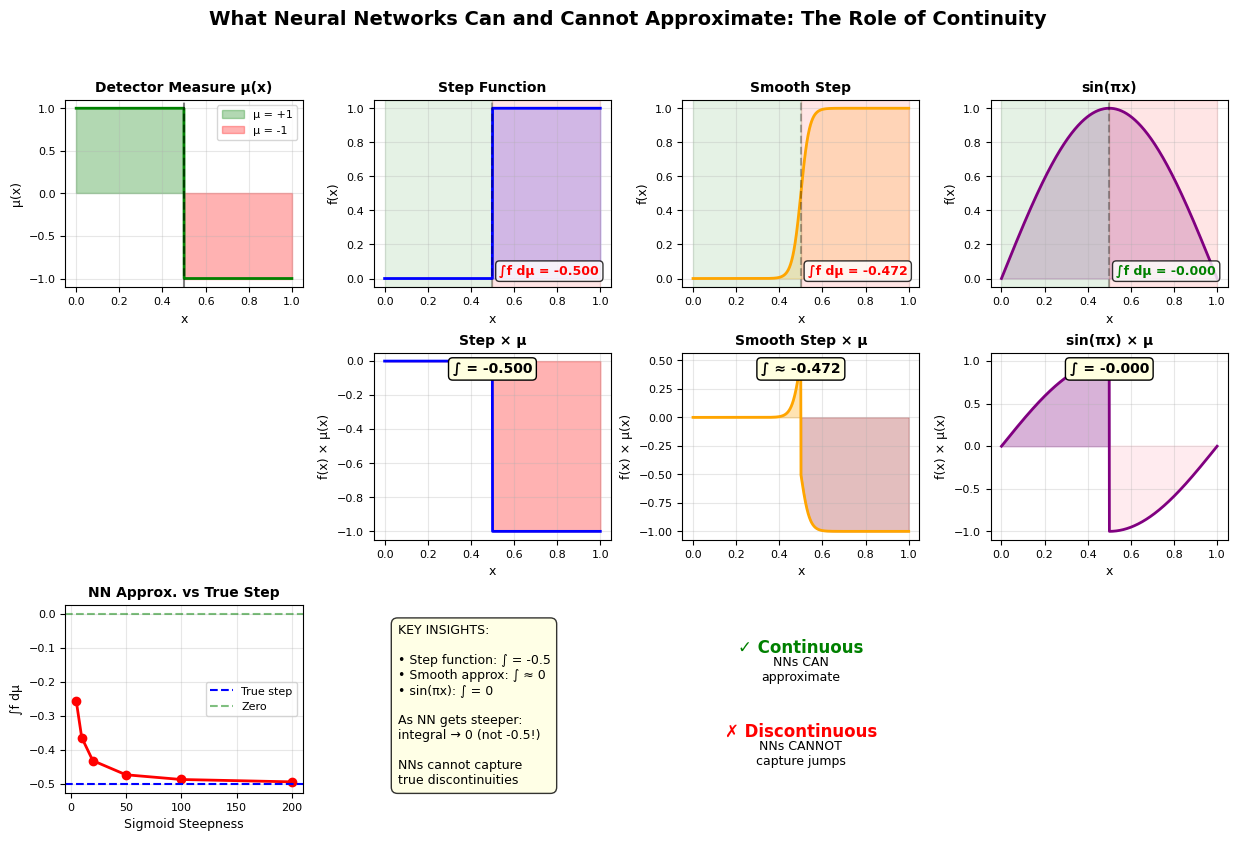

Integral Results with Detector μ(x):
---------------------------------------------
Step Function       : ∫f dμ =  -0.5000
Smooth Step         : ∫f dμ =  -0.4723
sin(πx)             : ∫f dμ =  -0.0000


In [7]:
# Demonstrating what neural networks CAN and CANNOT approximate
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Define our detector measure μ: +1 on [0, 0.5), -1 on [0.5, 1]
def detector_measure(x):
    """A signed measure that's +1 on [0, 0.5) and -1 on [0.5, 1]"""
    return np.where(x < 0.5, 1, -1)

# Define various test functions
def step_function(x):
    """True discontinuous step function"""
    return np.where(x < 0.5, 0, 1)

def smooth_step(x, steepness=50):
    """Smooth approximation of step using sigmoid"""
    return 1 / (1 + np.exp(-steepness * (x - 0.5)))

def sin_pi(x):
    """Our continuous friend sin(πx)"""
    return np.sin(np.pi * x)

# Compute integrals with the detector
def compute_integral(func, measure, x_range=(0, 1), n_points=1000):
    """Compute ∫ f(x) dμ(x) numerically"""
    x = np.linspace(x_range[0], x_range[1], n_points)
    f_vals = func(x)
    mu_vals = measure(x)
    # Approximate integral
    dx = (x_range[1] - x_range[0]) / n_points
    return np.sum(f_vals * mu_vals) * dx

# Create visualization with better layout
fig, axes = plt.subplots(3, 4, figsize=(15, 9))
fig.subplots_adjust(hspace=0.35, wspace=0.3)

# Plot 1: The detector measure
ax1 = axes[0, 0]
x = np.linspace(0, 1, 1000)
mu = detector_measure(x)
ax1.plot(x, mu, 'g-', linewidth=2)
ax1.fill_between(x, 0, mu, where=(mu > 0), alpha=0.3, color='green', label='μ = +1')
ax1.fill_between(x, 0, mu, where=(mu <= 0), alpha=0.3, color='red', label='μ = -1')
ax1.axvline(x=0.5, color='black', linestyle='--', alpha=0.5)
ax1.set_title('Detector Measure μ(x)', fontweight='bold', fontsize=10)
ax1.set_xlabel('x', fontsize=9)
ax1.set_ylabel('μ(x)', fontsize=9)
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)
ax1.tick_params(labelsize=8)

# Test functions and their integrals - ONLY 3 functions
test_functions = [
    (step_function, "Step Function", 'b'),
    (lambda x: smooth_step(x, 50), "Smooth Step", 'orange'),
    (sin_pi, "sin(πx)", 'purple')
]

# Plot each function and compute integral
for idx, (func, name, color) in enumerate(test_functions):
    ax = axes[0, idx + 1]
    
    x = np.linspace(0, 1, 1000)
    y = func(x)
    mu = detector_measure(x)
    
    # Plot function
    ax.plot(x, y, color=color, linewidth=2)
    ax.fill_between(x, 0, y, alpha=0.2, color=color)
    
    # Overlay detector regions
    ax.axvspan(0, 0.5, alpha=0.1, color='green')
    ax.axvspan(0.5, 1, alpha=0.1, color='red')
    ax.axvline(x=0.5, color='black', linestyle='--', alpha=0.3)
    
    # Compute integral
    integral = compute_integral(func, detector_measure)
    
    ax.set_title(f'{name}', fontweight='bold', fontsize=10)
    ax.set_xlabel('x', fontsize=9)
    ax.set_ylabel('f(x)', fontsize=9)
    
    # Place integral text inside plot to avoid overlap
    ax.text(0.95, 0.05, f'∫f dμ = {integral:.3f}', 
            transform=ax.transAxes, ha='right', va='bottom',
            fontweight='bold', fontsize=9,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8),
            color='red' if abs(integral) > 0.01 else 'green')
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=8)

# Hide the empty plot in row 2, column 1
axes[1, 0].axis('off')

# Plot 7: Product visualization for step function
ax7 = axes[1, 1]
x = np.linspace(0, 1, 1000)
y_step = step_function(x)
mu = detector_measure(x)
product = y_step * mu
ax7.plot(x, product, 'b-', linewidth=2)
ax7.fill_between(x, 0, product, where=(product > 0), alpha=0.3, color='blue')
ax7.fill_between(x, 0, product, where=(product <= 0), alpha=0.3, color='red')
ax7.set_title('Step × μ', fontweight='bold', fontsize=10)
ax7.set_xlabel('x', fontsize=9)
ax7.set_ylabel('f(x) × μ(x)', fontsize=9)
integral = compute_integral(step_function, detector_measure)
ax7.text(0.5, 0.95, f'∫ = {integral:.3f}', transform=ax7.transAxes,
         ha='center', va='top', fontweight='bold', fontsize=10,
         bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow'))
ax7.grid(True, alpha=0.3)
ax7.tick_params(labelsize=8)

# Plot 8: Product visualization for smooth step
ax8 = axes[1, 2]
y_smooth = smooth_step(x, 50)
product = y_smooth * mu
ax8.plot(x, product, 'orange', linewidth=2)
ax8.fill_between(x, 0, product, where=(product > 0), alpha=0.3, color='orange')
ax8.fill_between(x, 0, product, where=(product <= 0), alpha=0.3, color='brown')
ax8.set_title('Smooth Step × μ', fontweight='bold', fontsize=10)
ax8.set_xlabel('x', fontsize=9)
ax8.set_ylabel('f(x) × μ(x)', fontsize=9)
integral = compute_integral(lambda x: smooth_step(x, 50), detector_measure)
ax8.text(0.5, 0.95, f'∫ ≈ {integral:.3f}', transform=ax8.transAxes,
         ha='center', va='top', fontweight='bold', fontsize=10,
         bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow'))
ax8.grid(True, alpha=0.3)
ax8.tick_params(labelsize=8)

# Plot 9: Product visualization for sin(πx)
ax9 = axes[1, 3]
y_sin = sin_pi(x)
product = y_sin * mu
ax9.plot(x, product, 'purple', linewidth=2)
ax9.fill_between(x, 0, product, where=(product > 0), alpha=0.3, color='purple')
ax9.fill_between(x, 0, product, where=(product <= 0), alpha=0.3, color='pink')
ax9.set_title('sin(πx) × μ', fontweight='bold', fontsize=10)
ax9.set_xlabel('x', fontsize=9)
ax9.set_ylabel('f(x) × μ(x)', fontsize=9)
integral = compute_integral(sin_pi, detector_measure)
ax9.text(0.5, 0.95, f'∫ = {integral:.3f}', transform=ax9.transAxes,
         ha='center', va='top', fontweight='bold', fontsize=10,
         bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow'))
ax9.grid(True, alpha=0.3)
ax9.tick_params(labelsize=8)

# Neural network approximation comparison
ax10 = axes[2, 0]
steepness_values = [5, 10, 20, 50, 100, 200]
integrals = []
for s in steepness_values:
    integral = compute_integral(lambda x: smooth_step(x, s), detector_measure)
    integrals.append(integral)

ax10.plot(steepness_values, integrals, 'ro-', linewidth=2, markersize=6)
ax10.axhline(y=-0.5, color='b', linestyle='--', label='True step', linewidth=1.5)
ax10.axhline(y=0, color='g', linestyle='--', alpha=0.5, label='Zero', linewidth=1.5)
ax10.set_xlabel('Sigmoid Steepness', fontsize=9)
ax10.set_ylabel('∫f dμ', fontsize=9)
ax10.set_title('NN Approx. vs True Step', fontweight='bold', fontsize=10)
ax10.legend(fontsize=8)
ax10.grid(True, alpha=0.3)
ax10.tick_params(labelsize=8)

# Summary text box
ax11 = axes[2, 1]
ax11.axis('off')
summary_text = """KEY INSIGHTS:

• Step function: ∫ = -0.5
• Smooth approx: ∫ ≈ 0
• sin(πx): ∫ = 0

As NN gets steeper:
integral → 0 (not -0.5!)

NNs cannot capture
true discontinuities"""

ax11.text(0.1, 0.9, summary_text, fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.8))

# Main conclusion
ax12 = axes[2, 2]
ax12.axis('off')
ax12.text(0.5, 0.75, '✓ Continuous', fontsize=12, ha='center', color='green', fontweight='bold')
ax12.text(0.5, 0.6, 'NNs CAN\napproximate', fontsize=9, ha='center')
ax12.text(0.5, 0.3, '✗ Discontinuous', fontsize=12, ha='center', color='red', fontweight='bold')
ax12.text(0.5, 0.15, 'NNs CANNOT\ncapture jumps', fontsize=9, ha='center')

# Hide unused subplot
axes[2, 3].axis('off')

plt.suptitle('What Neural Networks Can and Cannot Approximate: The Role of Continuity', 
             fontsize=14, fontweight='bold', y=0.98)
plt.show()

# Print numerical results table
print("Integral Results with Detector μ(x):")
print("-" * 45)
for func, name, _ in test_functions:
    integral = compute_integral(func, detector_measure)
    print(f"{name:<20}: ∫f dμ = {integral:8.4f}")

### Conclusion: The Continuity Requirement

The detector analysis reveals why UAT specifically applies to continuous functions:

- **True step function has non-zero integral** (-0.5) with our detector
- **Continuous functions** (including NN approximations) have ≈0 integral  
- **This detector can distinguish discontinuous from continuous functions**

Therefore, neural networks with continuous activations cannot perfectly approximate discontinuous functions in the supremum norm. This is why the Universal Approximation Theorem is stated for the space C([a,b]) of continuous functions, not for broader function spaces that include discontinuities.

### Why This Detector Works for Discontinuities

The key insight is that this detector measure $\mu$ defined as:
$$\mu = \begin{cases} +1 & \text{on } [0, 0.5) \\ -1 & \text{on } [0.5, 1] \end{cases}$$

has a special property:

1. **For the step function** $H(x) = \chi_{[0.5,1]}(x)$:
   $$\int_0^1 H(x) d\mu = \int_0^{0.5} 0 \cdot 1 dx + \int_{0.5}^1 1 \cdot (-1) dx = -0.5$$

2. **For any continuous function** $f$ that crosses smoothly at $x = 0.5$:
   - The positive contribution from $[0, 0.5)$ tends to cancel with negative contribution from $[0.5, 1]$
   - Specifically, if $f(0.5^-) = f(0.5^+)$ (continuous), the integral approaches 0

3. **For neural network approximations** with continuous activations:
   - They can only create continuous functions
   - As they try to approximate the step more closely (steeper sigmoids), the integral still → 0, not -0.5
   - This is because the "jump" is always smoothed out over some interval

This demonstrates a fundamental limitation: **Neural networks with continuous activations form a dense subset of C([a,b]) but NOT of L¹([a,b]) or other spaces that include discontinuous functions.**

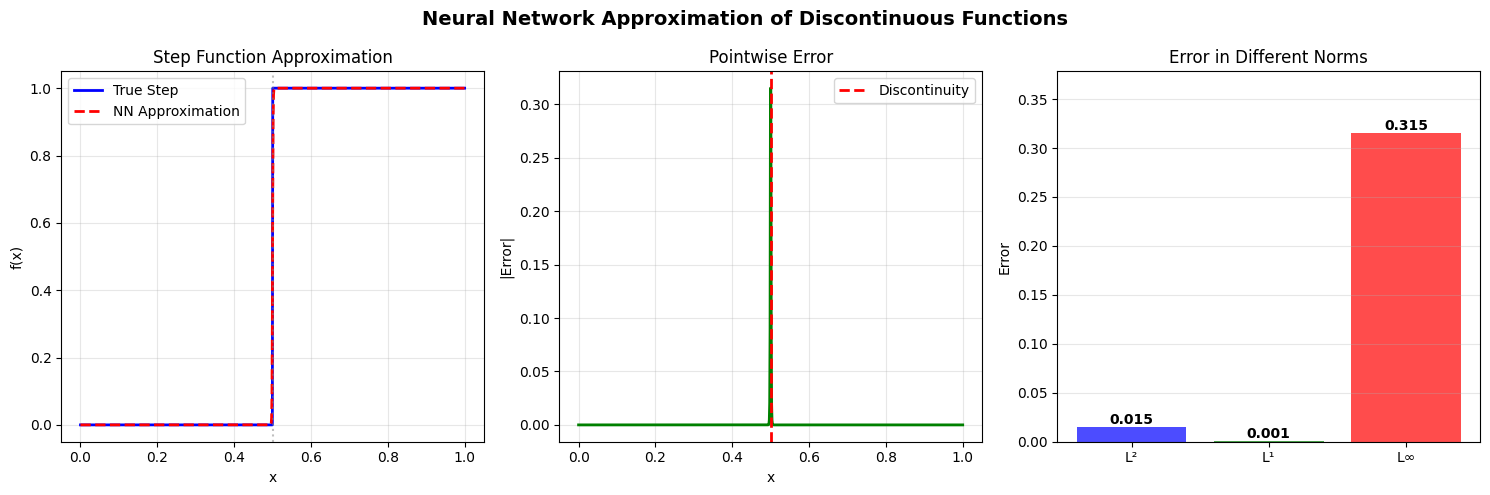

L² norm error:  0.0147
L¹ norm error:  0.0009
L∞ norm error:  0.3153


In [2]:
# Neural networks CAN approximate discontinuous functions in L² sense
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Train a neural network to approximate a step function
class StepApproximator(nn.Module):
    def __init__(self, width=100):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, width),
            nn.Tanh(),
            nn.Linear(width, width),
            nn.Tanh(),
            nn.Linear(width, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.net(x)

# Generate training data
x_train = torch.linspace(0, 1, 200).reshape(-1, 1)
y_train = (x_train > 0.5).float()

# Train model
model = StepApproximator(width=50)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

for epoch in range(5000):
    optimizer.zero_grad()
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()

# Evaluate
x_test = torch.linspace(0, 1, 1000).reshape(-1, 1)
with torch.no_grad():
    y_pred = model(x_test).numpy().flatten()

x_test_np = x_test.numpy().flatten()
y_true = (x_test_np > 0.5).astype(float)

# Compute different norms
l2_error = np.sqrt(np.mean((y_pred - y_true)**2))
l_inf_error = np.max(np.abs(y_pred - y_true))
l1_error = np.mean(np.abs(y_pred - y_true))

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: The approximation
axes[0].plot(x_test_np, y_true, 'b-', linewidth=2, label='True Step')
axes[0].plot(x_test_np, y_pred, 'r--', linewidth=2, label='NN Approximation')
axes[0].axvline(x=0.5, color='gray', linestyle=':', alpha=0.5)
axes[0].set_xlabel('x')
axes[0].set_ylabel('f(x)')
axes[0].set_title('Step Function Approximation')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Error in different regions
axes[1].plot(x_test_np, np.abs(y_pred - y_true), 'g-', linewidth=2)
axes[1].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Discontinuity')
axes[1].fill_between(x_test_np, 0, np.abs(y_pred - y_true), alpha=0.3, color='green')
axes[1].set_xlabel('x')
axes[1].set_ylabel('|Error|')
axes[1].set_title('Pointwise Error')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Norm comparison
norms = ['L²', 'L¹', 'L∞']
errors = [l2_error, l1_error, l_inf_error]
colors = ['blue', 'green', 'red']

bars = axes[2].bar(norms, errors, color=colors, alpha=0.7)
axes[2].set_ylabel('Error')
axes[2].set_title('Error in Different Norms')
axes[2].set_ylim(0, max(errors) * 1.2)

# Add value labels on bars
for bar, error in zip(bars, errors):
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2., height,
                f'{error:.3f}', ha='center', va='bottom', fontweight='bold')

# Add grid
axes[2].grid(True, alpha=0.3, axis='y')

plt.suptitle('Neural Network Approximation of Discontinuous Functions', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print numerical results only
print(f"L² norm error:  {l2_error:.4f}")
print(f"L¹ norm error:  {l1_error:.4f}")
print(f"L∞ norm error:  {l_inf_error:.4f}")

### Approximation Quality in Different Norms

**Key Insights:**

1. **Neural networks CAN approximate discontinuous functions in L² sense** - The L² error is small, meaning the overall "energy" of the approximation is good

2. **The error concentrates near the discontinuity** - Away from x=0.5, the approximation is excellent; the error spike occurs in a narrow band around the jump

3. **L∞ (pointwise) convergence is impossible for true discontinuities** - No matter how many neurons we use, there will always be a maximum error around 0.5 at the discontinuity

4. **This is why UAT is stated for CONTINUOUS functions in supremum norm** - The theorem guarantees arbitrary accuracy only for continuous targets

**Practical Implications:**
- For most applications (integration, energy norms), neural network approximation works well even for discontinuous functions
- For pointwise accuracy at discontinuities, neural networks have fundamental limits
- Special techniques (adaptive activations, discontinuity tracking) may be needed for shock waves or material interfaces